# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

**Context**

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

**Background reading**

* Sutton and Barto (2018), Chapters 3 - 6

**Overview of this assignment**

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Off-policy Bellman operators with function approximation

# Setup

### Import Useful Libraries

In [18]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [19]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [20]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)
  

# Section 2: Off-policy Bellman operators with function approximation
# _(40 pts total for the whole section)_

## Q8: Bellman operator for prediction **[10 pts]**

We are going to implement a Bellman operator for a simple MDP. You should:


1. Write a value function `v(w, x)` that outputs a linear value estimate when we have weights `w` (a numpy vector) and feature vector `x` (a numpy vector of the same size).
2. Write an operator function `T(w, pi, mu, l, g)` that takes weights `w`, a target policy `pi`, a behaviour policy `mu`, a trace parameter `l`, and a discount `g`, and outputs an off-policy-corrected lambda-return.  For this question, implement the standard importance-weighted per-decision lambda-return. There will only be two actions, with the same policy in each state, so we can define `pi` to be a number which is the target probability of selecting action `a` in any state (s.t. `1 - pi` is the probability of selecting `b`), and similarly for the behaviour `mu`.
3. Write an expected weight update, that uses the above two functions to compute the **expected** weight update.  The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  The state features $x_1 = x(s_1)$ and $x_2 = x(s_2)$ for the two states are $x_1 = [1, 1]^{\top}$ and $x_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)


This is best interpreted as follows: the output of T should be a value function.  This value function should be the result of applying a Bellman operator to the current value function (as given by the weights w), where the Bellman operator should correspond to what you would expect to happen if you would step through the MDP with target policy π and behaviour μ while bootstrapping according to λ and discounting according to γ.

In [21]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

'''Input: w = weights
          pi = target policy
          mu = behaviour policy
          l = trace parameter
          g = discount factor'''
def v(w, x):
    v_w = w @ x # Linear value function v_w = w^T * x
    return v_w 

def T(w, pi, mu, l, g):
    rho_a = pi / mu  # Importance sampling for selecting action a
    rho_b = (1 - pi) / mu  # Importance sampling for selecting action b
    A1 = g * (1 - l) * (mu * rho_a * v(w, x1) + (1 - mu) * rho_b * v(w, x2)) # First term A1
    ratio = (mu * rho_a + (1 - mu) * rho_b) * g * l  # Ration of the geometric series
    G_t = A1 / (1 - ratio) # Formula for the sum of the geometric series (infinite = sum converges)
    return G_t

def expected_update(w, pi, mu, l, g, lr):
    # Update rule = learning rate * prediction error * feature vector
    #           = learning rate * ((prediction for x1 - linear value function for x1) * feature vector for x1 + ...
    #             ((prediction for x2 - linear value function for x2) * feature vector for x2))
    eu = lr * (mu * (T(w, pi, mu, l, g) - v(w, x1)) * x1 + (1 - mu) * (T(w, pi, mu, l, g) - v(w,  x2)) * x2) 
    return eu

The above equations are represeted to proof as follows:

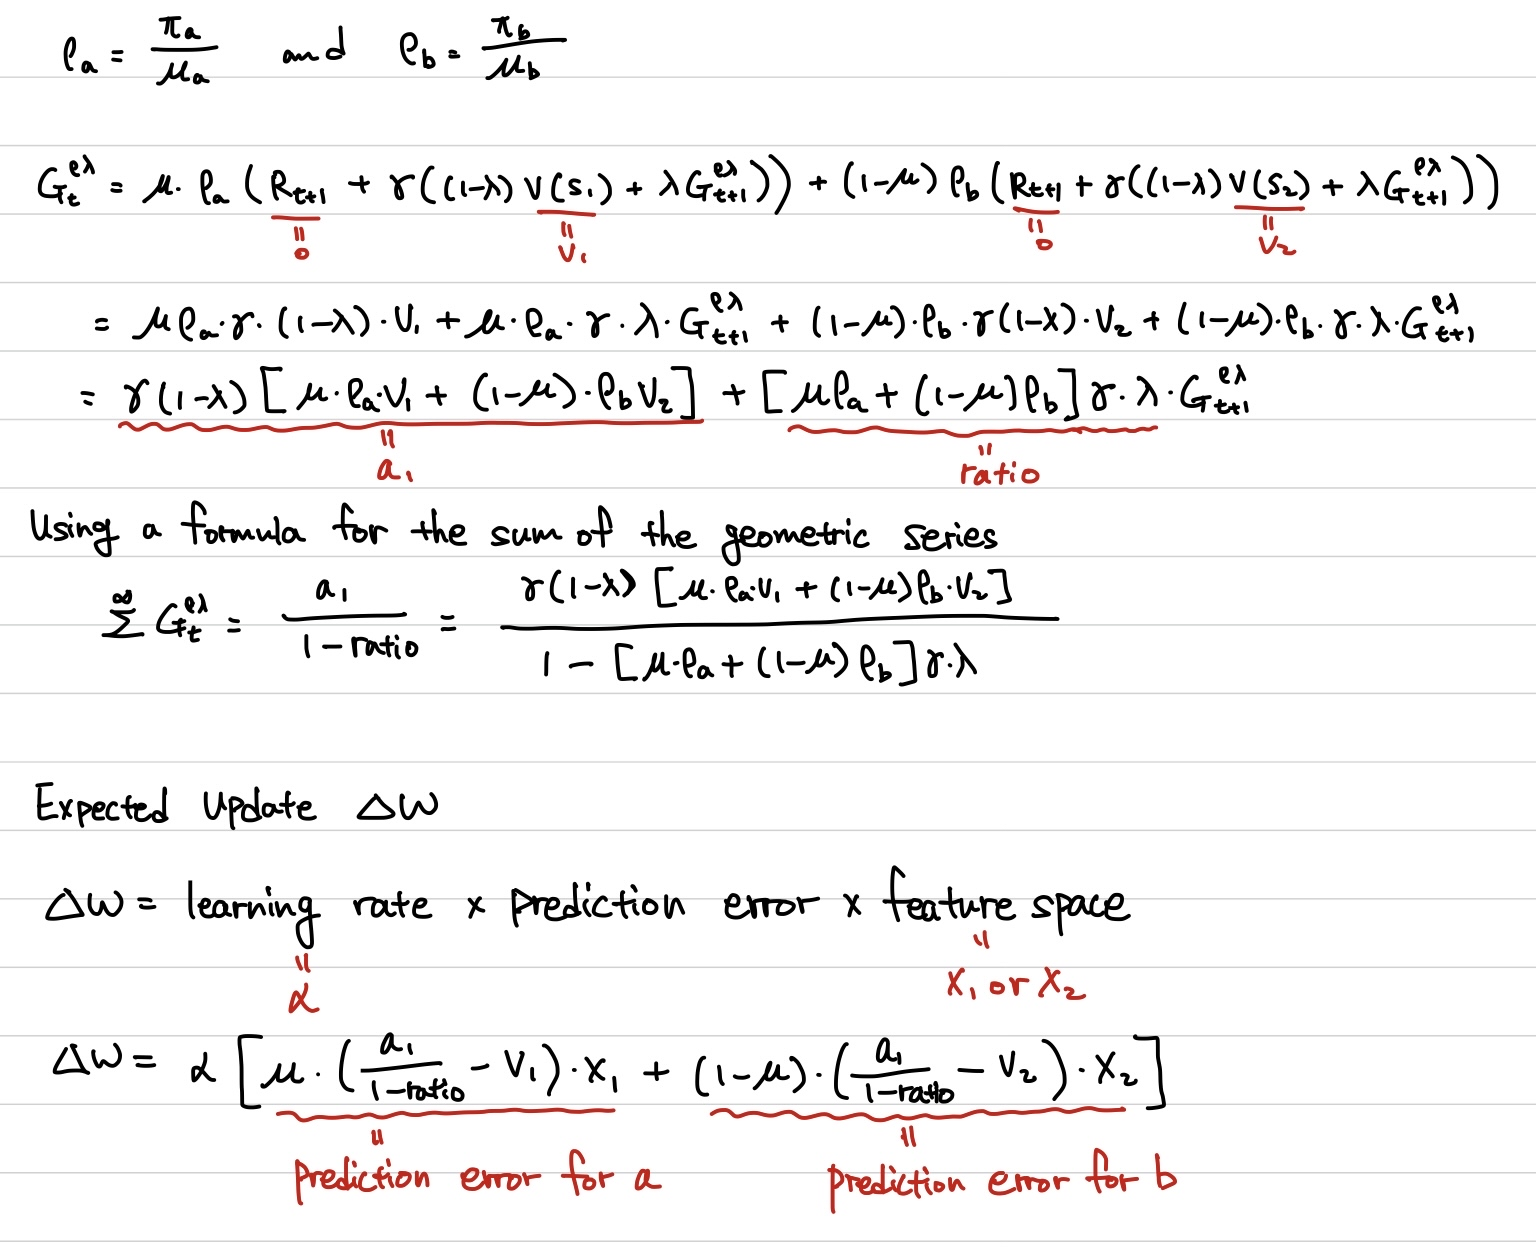

##Experiment 3: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

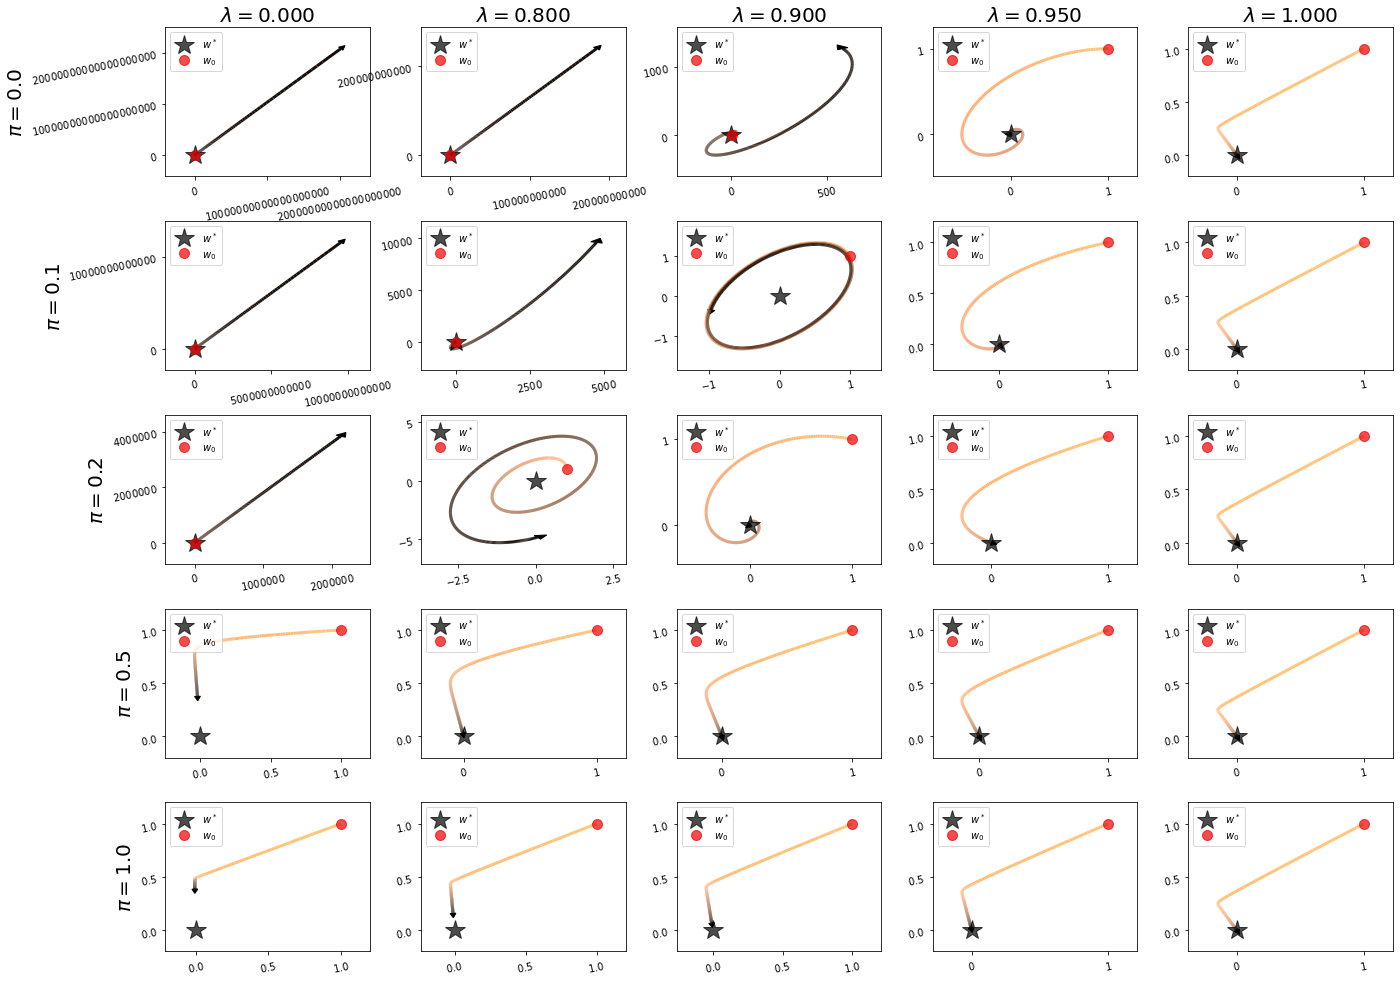

In [22]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q9: Analyse results (30 pts total)
1. **[2 pts]** How many of the above 25 experiments diverge?
1. **[4 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[4 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[4 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? (Do not limit the answer to the subset of values in the plots above, but to all choices of $\lambda$ and $\pi$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states.)
1. **[4 pts]** Why do all the plots corresponding to full Monte Carlo look the same?
1. **[4 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[4 pts]** How would the results above change (at high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?
1. **[4 pts]** Consider again the orginal experiment, where data is gathered under uniformly random behaviour policy. What would the updates to the vectors $w$ be under the $L_\infty$ norm? You can either run the experiment or give the closed-form update in an equation.


## Put answers to Q9 in this cell:
1. 8 experiments 

   i) $\pi = 0$ and $\lambda = 0$
   
   ii) $\pi = 0$ and $\lambda = 0.8$
   
   iii) $\pi = 0$ and $\lambda = 0.9$
   
   iv) $\pi = 0.1$ and $\lambda = 0$
   
   v) $\pi = 0.1$ and $\lambda = 0.8$
   
   vi) $\pi = 0.1$ and $\lambda = 0.9$
   
   vii) $\pi = 0.2$ and $\lambda = 0$
   
   viii) $\pi = 0.2$ and $\lambda = 0.8$


2. If the policy $\pi$ is zero, then the probability for selecting is only action b, which means going to section s2. On the other hand, if the policy $\pi$ is one, then the probability for selecting is only action a, which means going to section s1. Therefore, the probability of selecting action has absolute values (a or b), which means having only two options, so the results look asymmetric when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.


3. The function with a parameterized weight vector ($w$) is used to approximate the true value function and we are focusing on the linear function approximation. We are trying to learn the weight vector ($w$) and the feature vectors ($x_{1} and x_{2}$) contain information about a given state (s1 and s2). This question requires finding the weight vector ($w$) that allows the value function approximation to be as accurate as possible. If the policy ($\pi$) is close to 1, the plots seem to be more linear and closer to the optimal solution ($w_{*}$). Therefore, the true value function ($v_{\pi}$) can be representable when the policy ($\pi$) is close to 1. 


4. If the policy is zero, then the expected update would not converge properly. As shown in the above figures, they illustrate that we can infer the expected update converge or not by controlling the value of the policy. Moreover, the trace parameter helps to find the convergence properly and to reach the optimal solution. Therefore, we can represent as follows:
$$ 0 \leq \pi \leq 0.1 \ and \ \lambda \geq 0.95 : Convergence $$ 
$$ 0.1 \lt \pi \leq 0.2 \ and \ \lambda \geq 0.90 : Convergence $$
$$ 0.2 \lt \pi \lt 0.5 \ and \ \lambda \geq 0.80 : Convergence $$ 
$$ 0.5 \leq \pi \leq 1.0 \ and \ \lambda \geq 0 : Convergence $$ 

    However, some figures seem to not reach the optimal solution because the algorithm applies expected update only 1000 times. Furthermore, we need to recognise the direction of an arrow. This means that if the arrow changes the direction to go to the optimal solution, then it notices that they try to converge and if the expected update applies more than 1000 times, it might converges properly.
    
    
5. The Monte Carlo algorithm directly learns based on the episodes of experience, not as the knowledge of MDP transitions. It means that the algorithm updates after every episode, rather than after selecting all actions, and the final value represents the average return of all sample trajectories for each state. Therefore, all plots correspond to the full Monte Carlo look the same because of the mean return. 


6. In the case of Monte Carlo policy iterations, the policy evaluation and the policy improvement are alternated for each episode. At the end of each episode, the returns are used for the policy evaluation, and in all such visited states, the policy is improved after each episode. Thus, the above plots are corresponding the full Monte Carlo and those can be seen to be shaped depending on the policy.


7. If the behaviour policy ($\mu$) is 0.8, then the results would seem to be more easily reach the optimal solution ($w_*$) than the above results. For example, when the behaviour policy ($\mu$) is 0.8, the results would easily reach and help to converge to the optimal solution ($w_*$). On the other hand, if the behaviour policy ($\mu$) is small (e.g. less than $\mu$ = 0.2), the results possibly and easily occur divergence.


8. The linear value function with respect to weight and feature vector is $v_{w}(s) = w^{T}x(s)$, so if the update weight with TD has converged, the expected update would be zero and the fixed point will be this weight vector, which is called $w_{TD}$. This for the best fitting can be represented as follows:
$$ \mathbb{E}[R_{t+1} + \gamma v_{w}(S_{t+1}) - v_{w}(S_{t})x_{t}] = 0 $$
$$ w_{TD} = \mathbb{E}[x_{t}(x_{t} - \gamma x{t+1})^{T}]^{-1} \mathbb{E}[R_{t+1}x_{t}] $$
   
   From now, the average time grows to infinite and if the distribution is stationary, which needs to be the case that expectation has even existed, then a closed-form empirical loss equation actually were converged as the above expected equation. Moreover, the closed-form of the update weight vector is also similar to the above equation.
$$ \frac {1}{t} \sum_{i=0}^{t} (R_{t+1} + \gamma v_{w}(S_{t+1}) - v_{w}(S_{i}))x_{i} = 0 $$
$$ w_{t} = (\sum_{i=0}^{t} x_{i}(x_{i} - \gamma x_{t+1})^{T})^{-1} (\sum_{i=0}^{t}R_{t+1}x_{i}) $$

   In the update weight function, it can be updated seperately, so the first term is $(K_{t})^{-1}$ and the second term is $n_{t}$.
$$ (K_{t})^{-1} = (\sum_{i=0}^{t} x_{i}(x_{i} - \gamma x_{t+1})^{T})^{-1} $$
$$ n_{t} = (\sum_{i=0}^{t}R_{t+1}x_{i}) $$

   For using the Navie approach $(O(n^{3}))$, the inverse form of the first term can be represented with Sherman-Morrision as follows:
$$ K_{t+1} = K_{t} + x_{t}(x_{t} - \gamma x_{t+1})^{T} $$
$$ K_{t+1}^{-1} = K_{t}^{-1} - \frac {K_{t}^{-1}{x_{t}(x_{t} - \gamma x_{t+1})^{T}}K_{t}^{-1}}{1 + {(x_{t} - \gamma x_{t+1})^{T}}K_{t}^{-1}x_{t}}$$
$$ n_{t+1} = n_{t} + R_{t+1}x_{t} $$
